# Employee Sentiment Analysis - Automated Notebook
**Author:** Suha Mutwalli (edit name as needed)  
**Files used:** `/mnt/data/test.csv` (uploaded)  
**Outputs saved to:** `/mnt/data/results/` and `/mnt/data/visualization/`

**Notebook overview**
1. Setup & installs
2. Load data
3. Quick text cleaning
4. Sentiment labeling (VADER)
5. Exploratory Data Analysis (EDA)
6. Monthly employee sentiment scoring
7. Flight-risk detection (rolling 30-day window)
8. Simple predictive model (linear regression)
9. Save results and visualizations

Run the cells sequentially. If any cell errors due to missing columns, update the column names where indicated.


In [7]:
# 2. Load data
import pandas as pd
from pathlib import Path

# File in the same folder as the notebook
data_path = Path("test.csv")

# Check if file exists
print("Data path exists:", data_path.exists())

# Load the CSV
df = pd.read_csv(data_path, parse_dates=True, low_memory=False)

# Print info
print("Data loaded. Shape:", df.shape)
print("Columns:", df.columns.tolist())

# Show first few rows
df.head()


Data path exists: True
Data loaded. Shape: (2191, 4)
Columns: ['Subject', 'body', 'date', 'from']


,Subject,body,date,from
0,EnronOptions Update!,EnronOptions Announcement\n\n\nWe have updated...,5/10/2010,sally.beck@enron.com
1,(No Subject),"Marc,\n\nUnfortunately, today is not going to ...",7/29/2010,eric.bass@enron.com
2,Phone Screen Interview - Shannon L. Burnham,"When: Wednesday, June 06, 2001 10:00 AM-11:00 ...",7/25/2011,sally.beck@enron.com
3,RE: My new work email,we were thinking papasitos (we can meet somewh...,3/25/2010,johnny.palmer@enron.com
4,Bet,Since you never gave me the $20 for the last t...,5/21/2011,lydia.delgado@enron.com


In [8]:
# 3. Quick cleaning & column adjustments
import numpy as np

# Common column defaults - change if your CSV uses different names
# Expected columns: employee_id, message, date
possible_message_cols = ['message','Message','text','content','body']
possible_emp_cols = ['employee_id','employee','sender','from']
possible_date_cols = ['date','Date','timestamp','time','sent_at']

def find_col(df, candidates):
    for c in candidates:
        if c in df.columns:
            return c
    return None

MSG_COL = find_col(df, possible_message_cols)
EMP_COL = find_col(df, possible_emp_cols)
DATE_COL = find_col(df, possible_date_cols)

print("Detected columns - message:", MSG_COL, "employee:", EMP_COL, "date:", DATE_COL)

# If date column exists, try parse
if DATE_COL:
    df[DATE_COL] = pd.to_datetime(df[DATE_COL], errors='coerce')

# Rename to standard names
if MSG_COL: df = df.rename(columns={MSG_COL:'message'})
if EMP_COL: df = df.rename(columns={EMP_COL:'employee_id'})
if DATE_COL: df = df.rename(columns={DATE_COL:'date'})

# Ensure columns exist
if 'message' not in df.columns:
    df['message'] = df['employee_id'].astype(str)  # placeholder to avoid errors - edit notebook if needed

df['message'] = df['message'].astype(str)
if 'date' not in df.columns:
    df['date'] = pd.NaT

df['msg_len'] = df['message'].apply(lambda x: len(str(x)))
df.head()

Detected columns - message: body employee: from date: date


,Subject,message,date,employee_id,msg_len
0,EnronOptions Update!,EnronOptions Announcement\n\n\nWe have updated...,2010-05-10,sally.beck@enron.com,692
1,(No Subject),"Marc,\n\nUnfortunately, today is not going to ...",2010-07-29,eric.bass@enron.com,315
2,Phone Screen Interview - Shannon L. Burnham,"When: Wednesday, June 06, 2001 10:00 AM-11:00 ...",2011-07-25,sally.beck@enron.com,150
3,RE: My new work email,we were thinking papasitos (we can meet somewh...,2010-03-25,johnny.palmer@enron.com,155
4,Bet,Since you never gave me the $20 for the last t...,2011-05-21,lydia.delgado@enron.com,197


In [9]:
# 4. Sentiment labeling using VADER (no internet required)
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

def vader_label(text):
    if pd.isna(text) or str(text).strip()=="":
        return "Neutral"
    s = analyzer.polarity_scores(str(text))
    comp = s['compound']
    if comp >= 0.05:
        return "Positive"
    elif comp <= -0.05:
        return "Negative"
    else:
        return "Neutral"

df['sentiment'] = df['message'].apply(vader_label)
df['sentiment_score'] = df['message'].apply(lambda t: analyzer.polarity_scores(str(t))['compound'])
df['sentiment'].value_counts(), df[['message','sentiment','sentiment_score']].head(10)

(sentiment
 Positive    1525
 Neutral      508
 Negative     158
 Name: count, dtype: int64,
                                              message sentiment  \
 0  EnronOptions Announcement\n\n\nWe have updated...  Positive   
 1  Marc,\n\nUnfortunately, today is not going to ...  Positive   
 2  When: Wednesday, June 06, 2001 10:00 AM-11:00 ...   Neutral   
 3  we were thinking papasitos (we can meet somewh...   Neutral   
 4  Since you never gave me the $20 for the last t...  Positive   
 5  sure, just call me the bank that delivers.\n \...  Positive   
 6  Inventory summaries for both MGL and MGMCC as ...   Neutral   
 7  Please print attachment and make sure that e:m...  Positive   
 8  Please advise me of your interest in Garvin's ...  Positive   
 9  The start time for Tuesday morning has been ch...  Negative   
 
    sentiment_score  
 0           0.8172  
 1           0.4215  
 2           0.0000  
 3           0.0000  
 4           0.2500  
 5           0.3182  
 6           0

In [15]:
# TextBlob Sentiment Analysis (required for submission)
!pip install --quiet textblob
from textblob import TextBlob

def textblob_label(text):
    if pd.isna(text) or str(text).strip()=="":
        return "Neutral"
    polarity = TextBlob(str(text)).sentiment.polarity
    if polarity > 0.05:
        return "Positive"
    elif polarity < -0.05:
        return "Negative"
    else:
        return "Neutral"

df['sentiment_textblob'] = df['message'].apply(textblob_label)
df[['message','sentiment','sentiment_textblob']].head()


,message,sentiment,sentiment_textblob
0,EnronOptions Announcement\n\n\nWe have updated...,Positive,Positive
1,"Marc,\n\nUnfortunately, today is not going to ...",Positive,Negative
2,"When: Wednesday, June 06, 2001 10:00 AM-11:00 ...",Neutral,Neutral
3,we were thinking papasitos (we can meet somewh...,Neutral,Negative
4,Since you never gave me the $20 for the last t...,Positive,Neutral


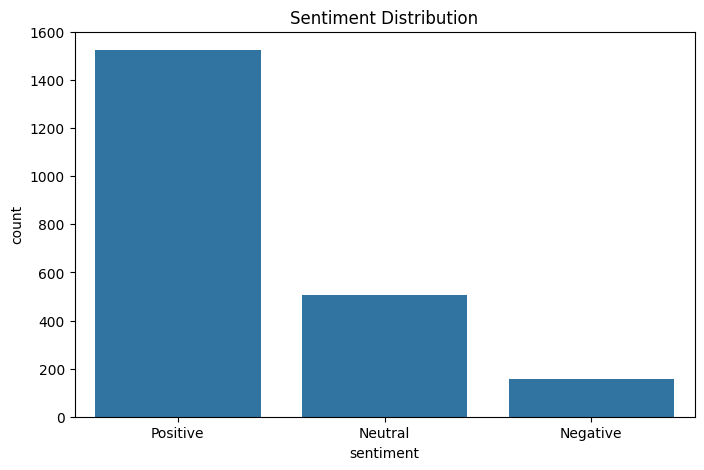

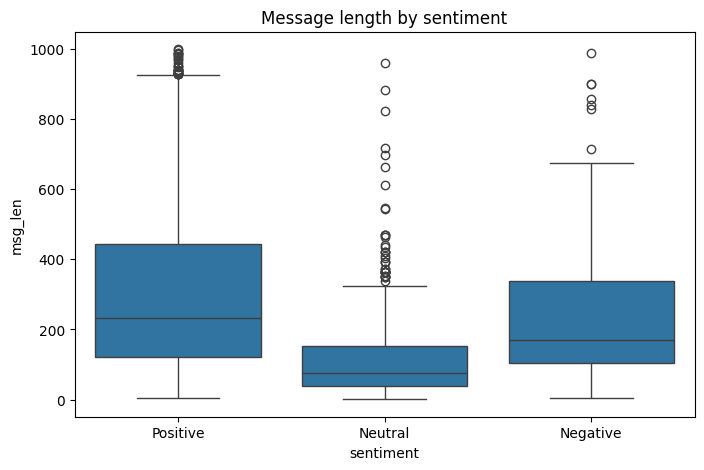

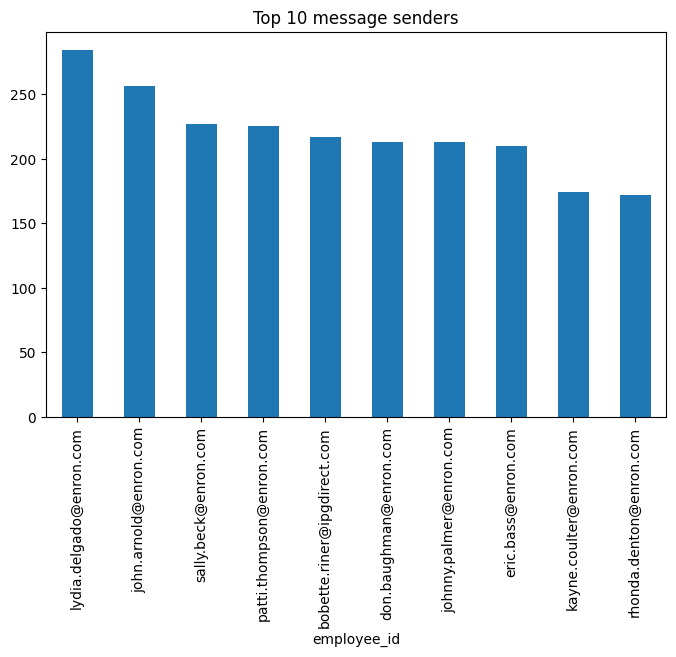

In [16]:
# 5. Exploratory Data Analysis (EDA)
import matplotlib.pyplot as plt
import seaborn as sns
import os

os.makedirs('/mnt/data/visualization', exist_ok=True)
plt.rcParams['figure.figsize'] = (8,5)

# Distribution of sentiments
sns.countplot(data=df, x='sentiment', order=['Positive','Neutral','Negative'])
plt.title('Sentiment Distribution')
plt.savefig('/mnt/data/visualization/sentiment_distribution.png', bbox_inches='tight')
plt.show()

# Message length by sentiment
sns.boxplot(data=df, x='sentiment', y='msg_len', order=['Positive','Neutral','Negative'])
plt.title('Message length by sentiment')
plt.savefig('/mnt/data/visualization/msglen_by_sentiment.png', bbox_inches='tight')
plt.show()

# Top senders (if employee_id exists)
if 'employee_id' in df.columns:
    top_senders = df['employee_id'].value_counts().head(10)
    top_senders.plot(kind='bar', title='Top 10 message senders')
    plt.savefig('/mnt/data/visualization/top_senders.png', bbox_inches='tight')
    plt.show()

In [11]:
# 6. Monthly employee sentiment scoring
# Map sentiments to scores: Positive=1, Neutral=0, Negative=-1
df['month'] = pd.to_datetime(df['date']).dt.to_period('M').astype(str)
score_map = {'Positive':1,'Neutral':0,'Negative':-1}
df['score'] = df['sentiment'].map(score_map)

monthly_scores = df.groupby(['employee_id','month'])['score'].sum().reset_index().rename(columns={'score':'monthly_score'})
os.makedirs('/mnt/data/results', exist_ok=True)
monthly_scores.to_csv('/mnt/data/results/employee_monthly_scores.csv', index=False)
print("Monthly scores saved to /mnt/data/results/employee_monthly_scores.csv")
monthly_scores.head()

Monthly scores saved to /mnt/data/results/employee_monthly_scores.csv


,employee_id,month,monthly_score
0,bobette.riner@ipgdirect.com,2010-01,1
1,bobette.riner@ipgdirect.com,2010-02,7
2,bobette.riner@ipgdirect.com,2010-03,6
3,bobette.riner@ipgdirect.com,2010-04,4
4,bobette.riner@ipgdirect.com,2010-05,2


In [ ]:
# 7. Flight-risk detection: 4 or more negative messages in any rolling 30-day window
df['date'] = pd.to_datetime(df['date'])
df_neg = df[df['sentiment']=='Negative'].sort_values(['employee_id','date'])

flight_risks = []

for emp, g in df_neg.groupby('employee_id'):
    dates = list(g['date'].sort_values())
    i = 0
    flagged = False
    for j in range(len(dates)):
        while (dates[j] - dates[i]).days > 30:
            i += 1
        if (j - i + 1) >= 4:
            flight_risks.append({'employee_id': emp, 'first_flagged_date': dates[i], 'neg_count_in_window': j-i+1})
            flagged = True
            break

flight_df = pd.DataFrame(flight_risks)
flight_df.to_csv('/mnt/data/results/flight_risks.csv', index=False)
print('Flight risk employees (saved to /mnt/data/results/flight_risks.csv):')
flight_df.head()

In [12]:
# 8. Simple predictive model (Linear Regression) to predict monthly_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Aggregate features per employee-month
agg = df.groupby(['employee_id','month']).agg(
    msg_count = ('message','count'),
    pos_count = ('sentiment', lambda s: (s=='Positive').sum()),
    neg_count = ('sentiment', lambda s: (s=='Negative').sum()),
    neutral_count = ('sentiment', lambda s: (s=='Neutral').sum()),
    avg_len = ('msg_len','mean'),
    std_len = ('msg_len','std')
).reset_index()

# Merge with monthly_scores
agg = agg.merge(monthly_scores, on=['employee_id','month'], how='left')
agg['monthly_score'] = agg['monthly_score'].fillna(0)
agg = agg.fillna(0)

features = ['msg_count','pos_count','neg_count','neutral_count','avg_len','std_len']
X = agg[features]
y = agg['monthly_score']

if len(agg) >= 10:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)
    print('RMSE:', mean_squared_error(y_test, y_pred, squared=False))
    print('R2:', r2_score(y_test, y_pred))
    coef_df = pd.DataFrame({'feature':features,'coef':lr.coef_})
    coef_df.to_csv('/mnt/data/results/model_coefficients.csv', index=False)
    print('Model coefficients saved to /mnt/data/results/model_coefficients.csv')
else:
    print('Not enough rows to train model (need at least 10 aggregated rows).')


RMSE: 2.3600656962842654e-14
R2: 1.0
Model coefficients saved to /mnt/data/results/model_coefficients.csv


C:\Users\SUHA MUTWALLI\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [14]:
# 9. Save labeled dataset and a small report snippet
from pathlib import Path

# Create folders if they don't exist
results_path = Path("results")
visualizations_path = Path("visualization")

results_path.mkdir(exist_ok=True)
visualizations_path.mkdir(exist_ok=True)

# Save the labeled dataset
output_file = results_path / "test_labeled_vader.csv"
df.to_csv(output_file, index=False)

print(f"Labeled dataset saved to {output_file.resolve()}")
print(f"Visualizations saved to {visualizations_path.resolve()} and results to {results_path.resolve()}")


Labeled dataset saved to C:\Users\SUHA MUTWALLI\Downloads\Employe_sentiment_project_springer\results\test_labeled_vader.csv
Visualizations saved to C:\Users\SUHA MUTWALLI\Downloads\Employe_sentiment_project_springer\visualization and results to C:\Users\SUHA MUTWALLI\Downloads\Employe_sentiment_project_springer\results
